In [1]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool

In [2]:
def line(x, a, b):
    return a*x + b

In [3]:
def simulation(param):
    P1, P2 = param
    ecc1, ecc0, ecc2 = 0.03, 0.07, 0.016
    mu1, mu2 = 36e-6, 28e-6
    pomega1, pomega0, pomega2 = -0.4, -0.86, 0
    P_0, lambda_0 = 0.05, 0

    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc0, pomega=pomega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    
    # calculate megno
    time = np.logspace(0,5,num=100)*P_0
    for T in time:
        try:
            sim.integrate(T, exact_finish_time=0)
            if sim.calculate_megno() >= 2.5:
                megno = np.zeros(200)
                sim_time = np.linspace(sim.t, 20*sim.t, num=200)
                for i, t in enumerate(sim_time):
                    try:
                        sim.integrate(t, exact_finish_time=0)
                        m = sim.calculate_megno()
                        megno[i] = m
                        if m >= 50:
                            break
                    except rebound.Collision:
                        break
                y = megno[megno != 0]
                x = sim_time[0:len(y)]
                try:
                    (popt, pcov) = curve_fit(line, x, y, maxfev=90000)
                    ly = 1/popt[0]
                    return ly
                except:
                    return 55555
        except rebound.Collision:
            return sim.t
    return 1e5

In [ ]:
Ngrid_x = 200
Ngrid_y = 200
P_0 = 0.05

r10 = np.linspace(0.60,0.76,Ngrid_x)
r20 = np.linspace(1.3,1.65,Ngrid_y)
parameters = [[P_0*x, P_0*y] for x in r10 for y in r20]

pool = InterruptiblePool()
results = pool.map(simulation,parameters)
np.savetxt("lyapunov_low_e.csv", results, delimiter=",")

In [10]:
def rescale(results):
    failed = np.zeros(len(results))
    ly_rescaled = np.zeros(len(results))
    for i in range(0,len(results)):
        ly = results[i][0]
        if ly == 55555:
            failed[i] = i
            ly_rescaled[i] = 7  # make failed points blank
        elif ly > 0:
            x = round(np.log10(ly/0.05))
            if x > 6:
                ly_rescaled[i] = 7
            else:
                ly_rescaled[i] = x
        else:
            failed[i] = i
            ly_rescaled[i] = 7
    return ly_rescaled, failed[failed != 0]

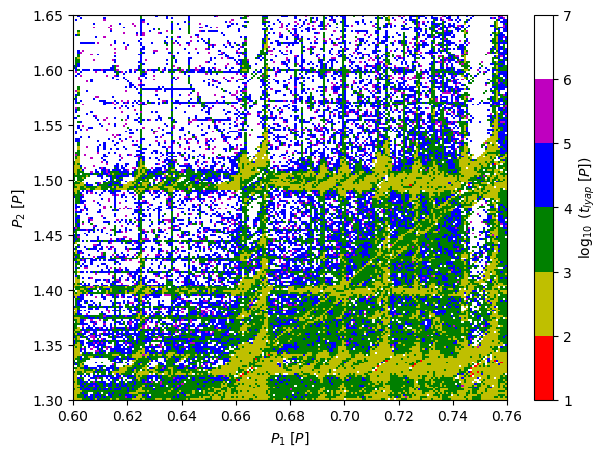

In [11]:
dataframe = pd.read_csv('lyapunov_low_e.csv', header=None)
data = dataframe.values
ly_rescaled, fail_index = rescale(data)
results2d = np.array(ly_rescaled).reshape(Ngrid_y,Ngrid_x)

fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(r10),max(r10),min(r20),max(r20)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel(r"$P_1$ [$P$]")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel(r"$P_2$ [$P$]")
im = ax.imshow(results2d.transpose(), interpolation="none", vmin=1, vmax=7, cmap=colors.ListedColormap(['r','y','g','b','m','w']), origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label(r"$\log_{10}$ ($t_{lyap}$ [$P$])")